In [1]:
import numpy as np
def adjust_with_random_margin(arr, min_val, max_val, margin):
    a = arr.copy()

    low_mask = a == min_val
    high_mask = a == max_val

    # Below min → min + random(0, margin)
    a[low_mask] = min_val + np.random.uniform(0, margin, size=low_mask.sum())

    # Above max → max - random(0, margin)
    a[high_mask] = max_val - np.random.uniform(0, margin, size=high_mask.sum())

    return a

In [2]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split

def generate_triangle_dataset(N=10000, bound_bottom=0.2, bound_left=0.2, test_size=0.2, random_seed=42):
    # Inputs
    X = torch.rand(N, 3)
    
    torch.manual_seed(random_seed)
    model_rand = torch.nn.Sequential(
        torch.nn.Linear(3, 8),
        torch.nn.Tanh(),
        torch.nn.Linear(8, 2)
    )
    
    # Generate raw outputs
    with torch.no_grad():
        Y = model_rand(X).numpy()
        Y += np.random.normal(loc=0.0, scale=0.01, size=Y.shape)
    
    # Normalize outputs
    y1_raw = (Y[:, 0] - Y[:, 0].min()) / (Y[:, 0].max() - Y[:, 0].min())
    y2_raw = (Y[:, 1] - Y[:, 1].min()) / (Y[:, 1].max() - Y[:, 1].min())
    
    # Apply triangle and margin constraints
    mask_1_1 = (y2_raw > 0.3) & (y2_raw < 0.4)
    mask_1_2 = (y2_raw > 0.4) & (y2_raw < 0.5)
    mask_1_3 = (y2_raw > 0.5) & (y2_raw < 0.6)
    mask_1_4 = (y2_raw > 0.6) & (y2_raw < 0.7)

    mask_2_1 = (y1_raw > 0.4) & (y1_raw < 0.7)
    mask_2_2 = ((y1_raw > 0.4) & (y1_raw < 0.5)) | ((y1_raw > 0.6) & (y1_raw < 0.7))
    mask_2_3 = ((y1_raw > 0.4) & (y1_raw < 0.5)) | ((y1_raw > 0.6) & (y1_raw < 0.7))
    mask_2_4 = ((y1_raw > 0.4) & (y1_raw < 0.5)) | ((y1_raw > 0.6) & (y1_raw < 0.7))

    mask = (mask_1_1 & mask_2_1 ) | (mask_1_2 & mask_2_2)| (mask_1_3 & mask_2_3)| (mask_1_4 & mask_2_4)


    
    X_filtered = X.numpy()[mask]
    y1_filtered = y1_raw[mask]
    y2_filtered = y2_raw[mask]
    y_filtered = np.stack([y1_filtered, y2_filtered], axis = 1)
    
    # violating_y1 = np.clip(y1_raw[~mask], 0.4, 0.7).copy()
    # violating_y2 = np.clip(y2_raw[~mask], 0.4, 0.6).copy()
    
    # violating_y1 = adjust_with_random_margin(violating_y1, 0.4, 0.7, margin= 0.2)
    # violating_y2 = adjust_with_random_margin(violating_y2, 0.4, 0.6, margin= 0.2)
    
    # y_violating = np.stack([violating_y1, violating_y2], axis = 1)
    
    # n_extra = int(len(y_filtered) * 0.2)
    # y_filtered = np.vstack([y_filtered, y_violating[:n_extra]])
    # X_filtered = np.vstack([X_filtered, X.numpy()[~mask][:n_extra]])

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_filtered, y_filtered, test_size=test_size, random_state=random_seed
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=test_size, random_state=random_seed
    )
    
    # Convert to tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test  = torch.tensor(X_test, dtype=torch.float32)
    X_val  = torch.tensor(X_val, dtype=torch.float32)
    
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test  = torch.tensor(y_test, dtype=torch.float32)
    y_val  = torch.tensor(y_val, dtype=torch.float32)
    
    return X_train, X_val, X_test, y_train, y_val, y_test


In [3]:
def train_model(model, train_loader, criterion, optimizer, epochs, X_val, Y_val, patience=100, print_freq=50):
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = model.state_dict() 
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        num_batches = 0

        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch, Y_batch[:,0])
            loss = criterion(outputs, Y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1

        avg_train_loss = total_loss / num_batches

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val, None, train = False)
            val_loss = criterion(val_outputs, Y_val).item()

        # 3. Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model state
            best_model_state = model.state_dict() 
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n[Early Stopping] Stopping at Epoch {epoch+1}. Validation loss has not improved for {patience} epochs.")
                break

        if (epoch + 1) % print_freq == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f} | Val Loss: {val_loss:.6f}")
    
    # Load the best model weights found during training before returning
    model.load_state_dict(best_model_state)
    print("--- Training Complete (Best Model Loaded) ---")
    return model

In [4]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_o1_o2(predicted, target, title="O1 vs O2", xlabel="O1", ylabel="O2", color_pred='blue', color_target='red', alpha=0.7):
    """
    Plots predicted and optional target points on the same scatter plot.
    - predicted: list or array of points [[o1, o2], ...]
    - target: optional list or array of points [[o1, o2], ...]
    """
    predicted = np.array(predicted)
    plt.figure(figsize=(6,6))

    # Plot predicted points
    plt.scatter(predicted[:, 0], predicted[:, 1], color=color_pred, alpha=alpha, label='Predicted')
    plt.scatter(target[:, 0], target[:, 1], color=color_target, alpha=alpha, label='Target')


    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.axis('equal')
    plt.legend()
    plt.show()


In [6]:
def check_violation(y1_raw,y2_raw):
    mask_1_1 = (y2_raw > 0.3) & (y2_raw < 0.4)
    mask_1_2 = (y2_raw > 0.4) & (y2_raw < 0.5)
    mask_1_3 = (y2_raw > 0.5) & (y2_raw < 0.6)
    mask_1_4 = (y2_raw > 0.6) & (y2_raw < 0.7)

    mask_2_1 = (y1_raw > 0.4) & (y1_raw < 0.7)
    mask_2_2 = ((y1_raw > 0.4) & (y1_raw < 0.5)) | ((y1_raw > 0.6) & (y1_raw < 0.7))
    mask_2_3 = ((y1_raw > 0.4) & (y1_raw < 0.5)) | ((y1_raw > 0.6) & (y1_raw < 0.7))
    mask_2_4 = ((y1_raw > 0.4) & (y1_raw < 0.5)) | ((y1_raw > 0.6) & (y1_raw < 0.7))

    mask = (mask_1_1 & mask_2_1 ) | (mask_1_2 & mask_2_2)| (mask_1_3 & mask_2_3)| (mask_1_4 & mask_2_4)
    return 1 - sum(mask)/len(mask)

In [7]:
X_train, X_valid, X_test, Y_train, Y_valid, Y_test = generate_triangle_dataset()

Epoch 25/1000 - Train Loss: 0.007701 | Val Loss: 0.006766
Epoch 50/1000 - Train Loss: 0.001266 | Val Loss: 0.001114
Epoch 75/1000 - Train Loss: 0.000571 | Val Loss: 0.000516
Epoch 100/1000 - Train Loss: 0.000504 | Val Loss: 0.000457
Epoch 125/1000 - Train Loss: 0.000492 | Val Loss: 0.000447
Epoch 150/1000 - Train Loss: 0.000488 | Val Loss: 0.000445
Epoch 175/1000 - Train Loss: 0.000490 | Val Loss: 0.000446
Epoch 200/1000 - Train Loss: 0.000489 | Val Loss: 0.000445
Epoch 225/1000 - Train Loss: 0.000486 | Val Loss: 0.000444

[Early Stopping] Stopping at Epoch 235. Validation loss has not improved for 50 epochs.
--- Training Complete (Best Model Loaded) ---
Violations predicted
Violations test tensor(0.)


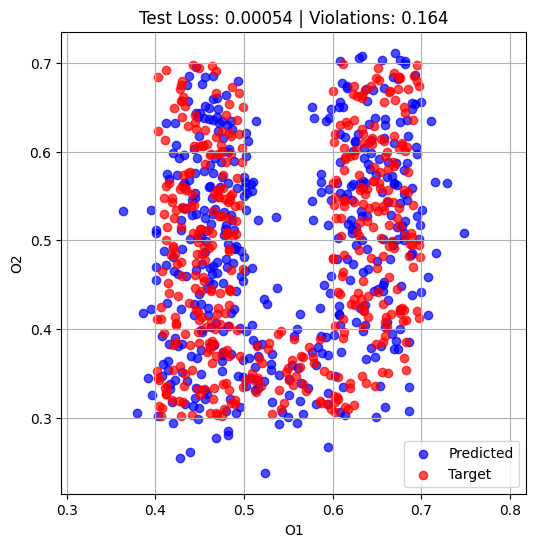

In [8]:
BATCH_SIZE = 64
BATCH_SIZE = 64
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


class TriangleNetInd(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 8),   # Input: 3 features (X1, X2, X3)
            nn.ReLU(),
            nn.Linear(8, 2),
        )
    
    def forward(self, x, target_o1, train = False):
        return self.net(x)


model = TriangleNetInd()

# 4. Define Training Parameters
EPOCHS = 1000
LEARNING_RATE = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 5. Run the Training
trained_model = train_model(
    model, 
    train_loader, 
    criterion, 
    optimizer, 
    EPOCHS, 
    X_valid,  # Pass the full X_val tensor
    Y_valid,  # Pass the full Y_val tensor
    patience=50, 
    print_freq=25
)


print("Violations predicted", )
print("Violations test", check_violation(Y_test[:,0],Y_test[:,1]))
trained_model.eval()
with torch.no_grad():
    # Get model predictions
    test_outputs = trained_model(X_test, None, train=False)
    
    # Compute test loss
    test_loss = criterion(test_outputs, Y_test).item()
    
    # Convert tensors to numpy arrays for plotting
    test_outputs_np = test_outputs.cpu().numpy()  # shape [N, 2]
    Y_test_np       = Y_test.cpu().numpy()       # shape [N, 2]
    
    # Compute violations if you have a function for that
    violations = check_violation(test_outputs_np[:,0], test_outputs_np[:,1])
    
    # Plot
    plot_o1_o2(
        predicted=test_outputs_np,
        target=Y_test_np,
        title=f"Test Loss: {test_loss:.5f} | Violations: {violations:.3f}"
    )
X_train, X_valid, X_test, Y_train, Y_valid, Y_test = (trained_model(X_train, None, train=False).detach().clone(),
                trained_model(X_valid, None, train=False).detach().clone(), trained_model(X_test, None, train=False).detach().clone(),
                Y_train, Y_valid, Y_test)

Epoch 25/1000 - Train Loss: 0.008678 | Val Loss: 0.007821
Epoch 50/1000 - Train Loss: 0.007595 | Val Loss: 0.007124
Epoch 75/1000 - Train Loss: 0.007367 | Val Loss: 0.006929
Epoch 100/1000 - Train Loss: 0.007086 | Val Loss: 0.006698
Epoch 125/1000 - Train Loss: 0.006758 | Val Loss: 0.006426
Epoch 150/1000 - Train Loss: 0.006366 | Val Loss: 0.006111
Epoch 175/1000 - Train Loss: 0.005887 | Val Loss: 0.005732
Epoch 200/1000 - Train Loss: 0.005281 | Val Loss: 0.005255
Epoch 225/1000 - Train Loss: 0.004554 | Val Loss: 0.004658
Epoch 250/1000 - Train Loss: 0.003741 | Val Loss: 0.003941
Epoch 275/1000 - Train Loss: 0.002943 | Val Loss: 0.003183
Epoch 300/1000 - Train Loss: 0.002246 | Val Loss: 0.002455
Epoch 325/1000 - Train Loss: 0.001667 | Val Loss: 0.001798
Epoch 350/1000 - Train Loss: 0.001194 | Val Loss: 0.001245
Epoch 375/1000 - Train Loss: 0.000859 | Val Loss: 0.000841
Epoch 400/1000 - Train Loss: 0.000672 | Val Loss: 0.000602
Epoch 425/1000 - Train Loss: 0.000589 | Val Loss: 0.000495


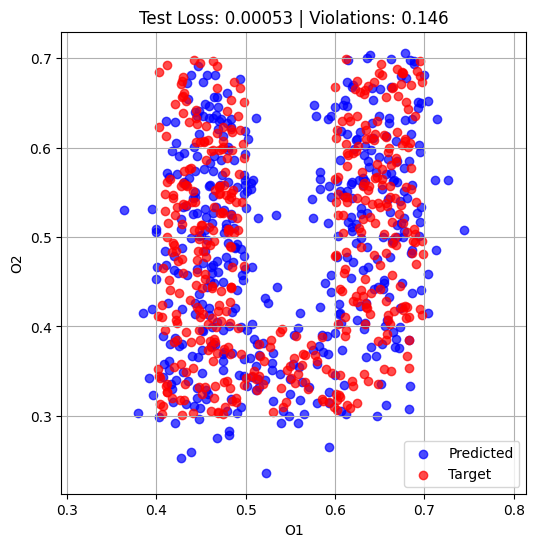

In [9]:
BATCH_SIZE = 128
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

class TriangleNetSeq(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 8),   # Input: 3 features (X1, X2, X3)
            nn.ReLU(),
            nn.Linear(8, 1),
        )
    
    def forward(self, x, target_o1, train = True):
        constant_feature = -1 * torch.ones(len(x), 1, device=x.device)
        x_with_constant = torch.cat([x, constant_feature], dim=1)
        output_1 = self.net(x_with_constant)
        if train:
            target_o1 = target_o1.unsqueeze(1)
            x_with_constant = torch.cat([x, target_o1], dim=1)
        else:
            x_with_constant = torch.cat([x, output_1], dim=1)
        output_2 = self.net(x_with_constant)
        return torch.cat([output_1, output_2], dim=1)
    

model = TriangleNetSeq()

# 4. Define Training Parameters
EPOCHS = 1000
LEARNING_RATE = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 5. Run the Training
trained_model = train_model(
    model, 
    train_loader, 
    criterion, 
    optimizer, 
    EPOCHS, 
    X_valid,  # Pass the full X_val tensor
    Y_valid,  # Pass the full Y_val tensor
    patience=50, 
    print_freq=25
)


print("Violations predicted", )
print("Violations test", check_violation(Y_test[:,0],Y_test[:,1]))
trained_model.eval()
with torch.no_grad():
    # Get model predictions
    test_outputs = trained_model(X_test, None, train=False)
    
    # Compute test loss
    test_loss = criterion(test_outputs, Y_test).item()
    
    # Convert tensors to numpy arrays for plotting
    test_outputs_np = test_outputs.cpu().numpy()  # shape [N, 2]
    Y_test_np       = Y_test.cpu().numpy()       # shape [N, 2]
    
    # Compute violations if you have a function for that
    violations = check_violation(test_outputs_np[:,0], test_outputs_np[:,1])
    
    # Plot
    plot_o1_o2(
        predicted=test_outputs_np,
        target=Y_test_np,
        title=f"Test Loss: {test_loss:.5f} | Violations: {violations:.3f}"
    )

Epoch 25/1000 - Train Loss: 0.023810 | Val Loss: 0.021440
Epoch 50/1000 - Train Loss: 0.007478 | Val Loss: 0.006806
Epoch 75/1000 - Train Loss: 0.006811 | Val Loss: 0.006189
Epoch 100/1000 - Train Loss: 0.005940 | Val Loss: 0.005365
Epoch 125/1000 - Train Loss: 0.004763 | Val Loss: 0.004290
Epoch 150/1000 - Train Loss: 0.003668 | Val Loss: 0.003337
Epoch 175/1000 - Train Loss: 0.002976 | Val Loss: 0.002732
Epoch 200/1000 - Train Loss: 0.002492 | Val Loss: 0.002303
Epoch 225/1000 - Train Loss: 0.002098 | Val Loss: 0.001949
Epoch 250/1000 - Train Loss: 0.001750 | Val Loss: 0.001621
Epoch 275/1000 - Train Loss: 0.001425 | Val Loss: 0.001316
Epoch 300/1000 - Train Loss: 0.001136 | Val Loss: 0.001037
Epoch 325/1000 - Train Loss: 0.000893 | Val Loss: 0.000803
Epoch 350/1000 - Train Loss: 0.000708 | Val Loss: 0.000628
Epoch 375/1000 - Train Loss: 0.000589 | Val Loss: 0.000517
Epoch 400/1000 - Train Loss: 0.000522 | Val Loss: 0.000460
Epoch 425/1000 - Train Loss: 0.000496 | Val Loss: 0.000439


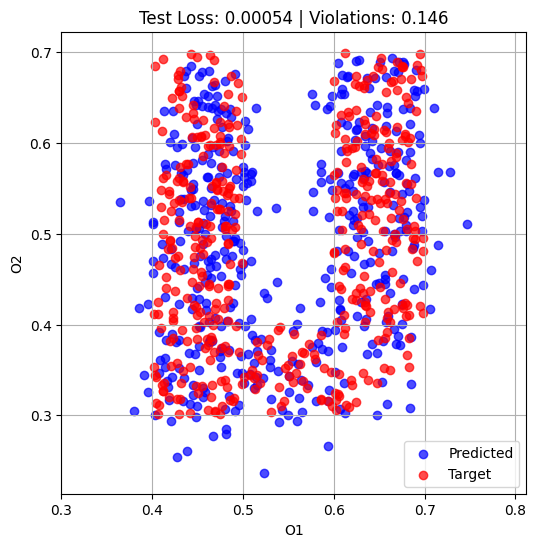

In [10]:
BATCH_SIZE = 128
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
class TriangleNetInd(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 8),   # Input: 3 features (X1, X2, X3)
            nn.ReLU(),
            nn.Linear(8, 2),
        )
    
    def forward(self, x, target_o1, train = False):
        return self.net(x)


model = TriangleNetInd()

# 4. Define Training Parameters
EPOCHS = 1000
LEARNING_RATE = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 5. Run the Training
trained_model = train_model(
    model, 
    train_loader, 
    criterion, 
    optimizer, 
    EPOCHS, 
    X_valid,  # Pass the full X_val tensor
    Y_valid,  # Pass the full Y_val tensor
    patience=50, 
    print_freq=25
)


print("Violations predicted", )
print("Violations test", check_violation(Y_test[:,0],Y_test[:,1]))
trained_model.eval()
with torch.no_grad():
    # Get model predictions
    test_outputs = trained_model(X_test, None, train=False)
    
    # Compute test loss
    test_loss = criterion(test_outputs, Y_test).item()
    
    # Convert tensors to numpy arrays for plotting
    test_outputs_np = test_outputs.cpu().numpy()  # shape [N, 2]
    Y_test_np       = Y_test.cpu().numpy()       # shape [N, 2]
    
    # Compute violations if you have a function for that
    violations = check_violation(test_outputs_np[:,0], test_outputs_np[:,1])
    
    # Plot
    plot_o1_o2(
        predicted=test_outputs_np,
        target=Y_test_np,
        title=f"Test Loss: {test_loss:.5f} | Violations: {violations:.3f}"
    )

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# =============== TRIANGLE PARAMETERS ===============
B = 1   # base
H = 1   # height

# =============== DATA GENERATION ===================
N = 6000
X = torch.rand(N, 3)

torch.manual_seed(42)
model_rand = nn.Sequential(
    nn.Linear(3, 8),
    nn.Tanh(),
    nn.Linear(8, 2)
)

with torch.no_grad():
    Y = model_rand(X).numpy()

# Normalize outputs between 0 and 1
y1_raw = (Y[:, 0] - Y[:, 0].min()) / (Y[:, 0].max() - Y[:, 0].min())
y2_raw = (Y[:, 1] - Y[:, 1].min()) / (Y[:, 1].max() - Y[:, 1].min())

bound_bottom = 0.2
bound_left = 0.2

mask_bottom = y2_raw > bound_bottom
mask_left = y1_raw > bound_left
mask_comb = y2_raw <= 1 - y1_raw

mask = mask_bottom & mask_left & mask_comb

# Filter inputs and outputs
X_np = X.numpy()
X_filtered = X_np[mask]
Y_filtered = np.stack([y1_raw[mask], y2_raw[mask]], axis=1)

print(f"Total filtered points: {len(Y_filtered)}")

# =============== TRAIN-TEST SPLIT ==================
X_train, X_test, Y_train, Y_test = train_test_split(
    X_filtered, Y_filtered, test_size=0.2, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

print(f"Train size: {len(Y_train)}, Test size: {len(Y_test)}")

# =============== DEFINE TRAINABLE MODEL ===============
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 8)
        self.act = nn.Tanh()
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

model = MyModel()


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 3000

# =============== TRAINING LOOP ========================
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.6f}")

# =============== FUNCTION TO COUNT VIOLATIONS ==========
def count_violations(y_pred, bound_bottom, bound_left):
    y1_pred = y_pred[:, 0]
    y2_pred = y_pred[:, 1]
    
    viol_bottom = y2_pred <= bound_bottom
    viol_left = y1_pred <= bound_left
    viol_comb = y2_pred > 1 - y1_pred
    
    violations = viol_bottom | viol_left | viol_comb
    return violations.sum().item(), len(y_pred)

# =============== EVALUATE VIOLATIONS ON TRAIN ===========
model.eval()
with torch.no_grad():
    preds_train = model(X_train)
    preds_test = model(X_test)

num_viol_train, total_train = count_violations(preds_train, bound_bottom, bound_left)
num_viol_test, total_test = count_violations(preds_test, bound_bottom, bound_left)

print(f"Train violations: {num_viol_train} / {total_train} ({100*num_viol_train/total_train:.2f}%)")
print(f"Test violations: {num_viol_test} / {total_test} ({100*num_viol_test/total_test:.2f}%)")

# =============== PLOT TEST PREDICTIONS ====================
plt.figure(figsize=(7,6))
plt.scatter(preds_test[:, 0].numpy(), preds_test[:, 1].numpy(), s=8, color="blue", alpha=0.5, label="Test Predicted")
plt.scatter(Y_test[:, 0].numpy(), Y_test[:, 1].numpy(), s=8, color="red", alpha=0.3, label="Test Ground Truth")

plt.plot([0, 0, B, 0], [0, H, 0, 0], 'k-', linewidth=2)
plt.plot([bound_left, 1, 1], [0, 0, 1-bound_left], 'g--', label='Margins & line')

plt.title(f"Test Set Predictions vs Ground Truth\nViolations: {num_viol_test}/{total_test}")
plt.xlabel("y1")
plt.ylabel("y2")
plt.legend()
plt.xlim(0, B)
plt.ylim(0, H)
plt.grid(True)
plt.show()


Total filtered points: 2144
Train size: 1715, Test size: 429


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1715x3 and 4x8)

Filtered points: 2150
Epoch 50/3000 - Loss: 0.033127
Epoch 100/3000 - Loss: 0.024409
Epoch 150/3000 - Loss: 0.021850
Epoch 200/3000 - Loss: 0.019564
Epoch 250/3000 - Loss: 0.017544
Epoch 300/3000 - Loss: 0.015952
Epoch 350/3000 - Loss: 0.014876
Epoch 400/3000 - Loss: 0.014194
Epoch 450/3000 - Loss: 0.013669
Epoch 500/3000 - Loss: 0.013109
Epoch 550/3000 - Loss: 0.012382
Epoch 600/3000 - Loss: 0.011364
Epoch 650/3000 - Loss: 0.009925
Epoch 700/3000 - Loss: 0.007979
Epoch 750/3000 - Loss: 0.005633
Epoch 800/3000 - Loss: 0.003316
Epoch 850/3000 - Loss: 0.001587
Epoch 900/3000 - Loss: 0.000662
Epoch 950/3000 - Loss: 0.000307
Epoch 1000/3000 - Loss: 0.000200
Epoch 1050/3000 - Loss: 0.000169
Epoch 1100/3000 - Loss: 0.000155
Epoch 1150/3000 - Loss: 0.000146
Epoch 1200/3000 - Loss: 0.000138
Epoch 1250/3000 - Loss: 0.000131
Epoch 1300/3000 - Loss: 0.000125
Epoch 1350/3000 - Loss: 0.000119
Epoch 1400/3000 - Loss: 0.000114
Epoch 1450/3000 - Loss: 0.000110
Epoch 1500/3000 - Loss: 0.000106
Epoch 15

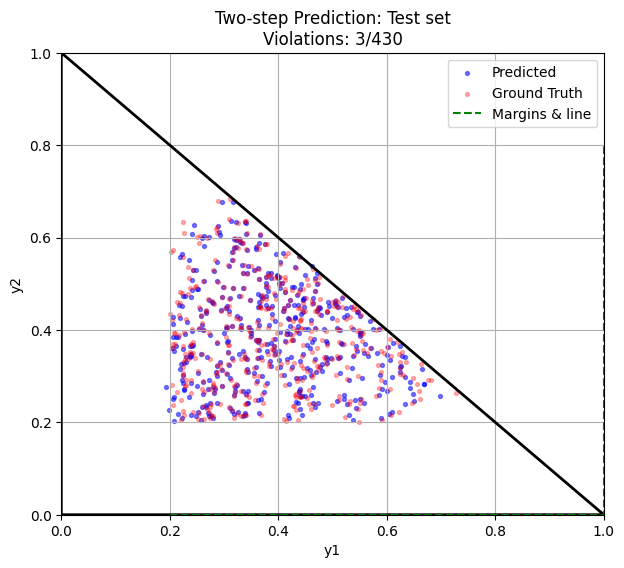

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# =============== TRIANGLE PARAMETERS ===============
B = 1
H = 1

# =============== DATA GENERATION ===================
N = 6000
X = torch.rand(N, 3)

torch.manual_seed(42)
model_rand = nn.Sequential(
    nn.Linear(3, 8),
    nn.Tanh(),
    nn.Linear(8, 2)
)

with torch.no_grad():
    Y = model_rand(X).numpy()

# Normalize outputs
y1_raw = (Y[:, 0] - Y[:, 0].min()) / (Y[:, 0].max() - Y[:, 0].min())
y2_raw = (Y[:, 1] - Y[:, 1].min()) / (Y[:, 1].max() - Y[:, 1].min())

bound_bottom = 0.2
bound_left = 0.2

mask_bottom = y2_raw > bound_bottom
mask_left = y1_raw > bound_left
mask_comb = y2_raw <= 1 - y1_raw
mask = mask_bottom & mask_left & mask_comb

X_np = X.numpy()
X_filtered = X_np[mask]
y1_filtered = y1_raw[mask]
y2_filtered = y2_raw[mask]

print(f"Filtered points: {len(y1_filtered)}")

# =============== PREPARE TRAIN-TEST SPLIT ===============
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(
    X_filtered, y1_filtered, y2_filtered, test_size=0.2, random_state=42
)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y1_train = torch.tensor(y1_train, dtype=torch.float32).unsqueeze(1)
y2_train = torch.tensor(y2_train, dtype=torch.float32).unsqueeze(1)

y1_test = torch.tensor(y1_test, dtype=torch.float32).unsqueeze(1)
y2_test = torch.tensor(y2_test, dtype=torch.float32).unsqueeze(1)

# =============== MODEL DEFINITION ===============
# Input size: 4 (3 original + 1 extra)
# Output size: 1 (predict y1 or y2)
model = nn.Sequential(
    nn.Linear(4, 8),
    nn.Tanh(),
    nn.Linear(8, 1)
)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 3000

# =============== TRAINING LOOP ===============
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Prepare inputs for y1 prediction: append -1 as 4th feature
    y1_inputs = torch.cat([X_train, -torch.ones((X_train.size(0), 1))], dim=1)
    y1_pred = model(y1_inputs)

    # Prepare inputs for y2 prediction: append predicted y1
    y2_inputs = torch.cat([X_train, y1_pred.detach()], dim=1)  # detach to avoid gradients flowing to y1 model step

    y2_pred = model(y2_inputs)

    # Loss = sum of y1 and y2 prediction losses
    loss = criterion(y1_pred, y1_train) + criterion(y2_pred, y2_train)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.6f}")

# =============== EVALUATION ===============
model.eval()
with torch.no_grad():
    # Predict y1 on test
    y1_inputs_test = torch.cat([X_test, -torch.ones((X_test.size(0), 1))], dim=1)
    y1_test_pred = model(y1_inputs_test)

    # Predict y2 on test, feeding predicted y1
    y2_inputs_test = torch.cat([X_test, y1_test_pred], dim=1)
    y2_test_pred = model(y2_inputs_test)

# Combine predictions for violations check
y1_pred_np = y1_test_pred.squeeze().numpy()
y2_pred_np = y2_test_pred.squeeze().numpy()

def count_violations(y1_pred, y2_pred, bound_bottom, bound_left):
    viol_bottom = y2_pred <= bound_bottom
    viol_left = y1_pred <= bound_left
    viol_comb = y2_pred > 1 - y1_pred
    violations = viol_bottom | viol_left | viol_comb
    return np.sum(violations), len(y1_pred)

num_viol, total = count_violations(y1_pred_np, y2_pred_np, bound_bottom, bound_left)
print(f"Violations on test set: {num_viol} / {total} ({100*num_viol/total:.2f}%)")

# =============== PLOT ===============
plt.figure(figsize=(7,6))
plt.scatter(y1_pred_np, y2_pred_np, s=8, color="blue", alpha=0.5, label="Predicted")
plt.scatter(y1_test.squeeze().numpy(), y2_test.squeeze().numpy(), s=8, color="red", alpha=0.3, label="Ground Truth")

plt.plot([0, 0, B, 0], [0, H, 0, 0], 'k-', linewidth=2)
plt.plot([bound_left, 1, 1], [0, 0, 1-bound_left], 'g--', label='Margins & line')

plt.title(f"Two-step Prediction: Test set\nViolations: {num_viol}/{total}")
plt.xlabel("y1")
plt.ylabel("y2")
plt.legend()
plt.xlim(0, B)
plt.ylim(0, H)
plt.grid(True)
plt.show()
